In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import trapezoid
from scipy.interpolate import UnivariateSpline

In [2]:
plt.style.use('fivethirtyeight')

In [3]:
# Parametros fijos del problema
#
# Datos de Concentracion del trazador en mmol/L vs tiempo en min 
c = np.array([1.00, 1.005, 1.02, 1.06, 1.20, 1.41, 1.61, 1.77, 1.92, 1.96, 2.00])
t = np.array([0, 5, 10, 15, 20, 30, 45, 60, 90, 120, 150])

# Calculo de la curva de distribucion acumulativa
## La funcion distribucion acumulativa F(t)

In [4]:
F = (c - c[0])/(c[-1] - c[0]) 

## Calculo de la curva E(t)


### Using forward differencing tecnique

\begin{equation*}
E(t) = \frac{F(t)}{dt} = \frac{F_{i+1} - F_{i}}{t_{i+1} - t_{i}}
\end{equation*}

In [5]:
E_forward = [(F[i+1] - F[i]) / (t[i+1] - t[i]) for i in range(0, len(F)-1)]

### Using central differencing tecnique

\begin{equation*}
E(t) = \frac{F(t)}{dt} = \frac{F_{i+1} - F_{i-1}}{t_{i+1} - t_{i-1}}
\end{equation*}

In [6]:
E_central = [(F[i+1] - F[i-1])/(t[i+1] - t[i-1]) for i in range(1, len(F)-1)]

### Using curve fitting tecnique

In [7]:
spl = UnivariateSpline(t, F, s=0)

t_adj = np.linspace(0, 150, 100)
F_adj = spl(t_adj)

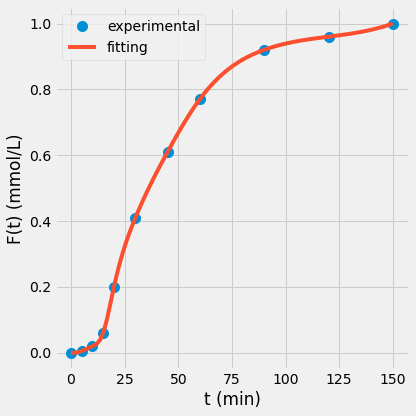

In [8]:
# Se dibuja la curva de concentracion del tracer en funcion del tiempo
fig, ax = plt.subplots(figsize=(6, 6))

ax.plot(t, F, markersize=10, marker='o', ls='None',
        label='experimental')
ax.plot(t_adj, F_adj, label='fitting') 

ax.set_xlabel('t (min)') 
ax.set_ylabel('F(t) (mmol/L)') 

plt.legend(loc='best')
plt.tight_layout()
plt.show()

In [9]:
E_adj = np.diff(F_adj)/np.diff(t_adj)

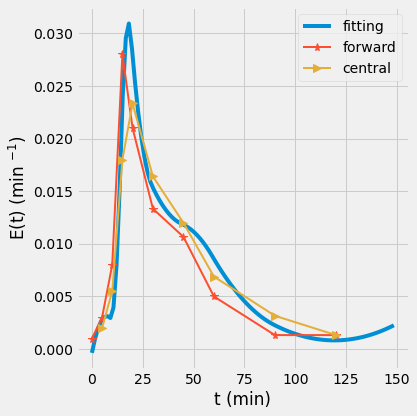

In [10]:
fig, ax = plt.subplots(figsize=(6, 6))

ax.plot(t_adj[0:-1], E_adj, label='fitting') 
ax.plot(t[0:-1], E_forward, markersize=8, marker='*', lw=2, label='forward') 
ax.plot(t[1:-1], E_central, markersize=8, marker='>', lw=2, label='central') 

ax.set_xlabel('t (min)') 
ax.set_ylabel('E(t) (min $^{-1}$)') 

ax.legend(loc='best')
plt.tight_layout()
plt.show()

# Calculating the first and second moments

In [11]:
tmean_forward = trapezoid(t[0:-1]* E_forward, t[0:-1]) 
tmean_fitting = trapezoid(t_adj[0:-1]* E_adj, t_adj[0:-1]) 
tmean_central = trapezoid(t[1:-1]* E_central, t[1:-1]) 

 
print('El tiempo medio de residencia (forward) es igual a {:1.3f} min'.format(tmean_forward))
print('El tiempo medio de residencia (fitting) es igual a {:1.3f} min'.format(tmean_fitting))
print('El tiempo medio de residencia (central) es igual a {:1.3f} min'.format(tmean_central))

El tiempo medio de residencia (forward) es igual a 30.675 min
El tiempo medio de residencia (fitting) es igual a 43.396 min
El tiempo medio de residencia (central) es igual a 39.650 min


# Which technique is the best?